# Basic Usage

In this notebook, we will show some typical use cases of the API  First, we import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cechmate as cm
from persim import plot_diagrams
import tadasets

## Rips Filtrations

First, we show how to do a rips filtration (NOTE: The [ripser.py](https://github.com/scikit-tda/ripser.py) library is strongly recommended in this case, so this is mainly to show syntax)

In [2]:
# Initialize a noisy circle
X = tadasets.dsphere(n=100, d=1, r=1, noise=0.2)

In [3]:
# Instantiate and build a rips filtration
rips = cm.Rips(maxdim=1) #Go up to 1D homology
rips.build(X)
dgmsrips = rips.diagrams()

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 2.62)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 1.39)


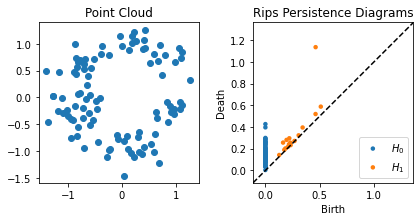

In [4]:
plt.figure()
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1])
plt.axis('square')
plt.title("Point Cloud")
plt.subplot(122)
plot_diagrams(dgmsrips)
plt.title("Rips Persistence Diagrams")
plt.tight_layout()
plt.show()

## Cech Filtrations

Let's try computing Cech filtrations.

In [5]:
cech = cm.Cech(maxdim=1) #Go up to 1D homology
cech.build(X)
dgmscech = cech.diagrams() * 2

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 2.84)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 2.18)


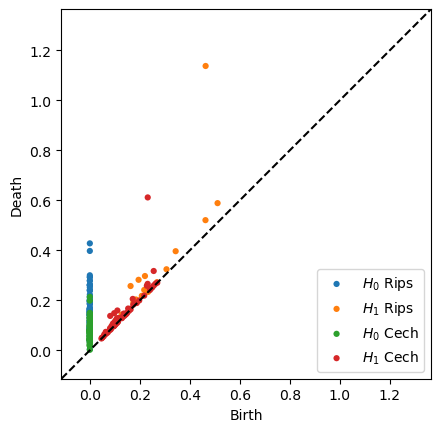

In [6]:
plot_diagrams(dgmsrips + dgmscech, labels = ['$H_0$ Rips', '$H_1$ Rips', '$H_0$ Cech', '$H_1$ Cech'])
plt.show()

## Alpha Filtrations

Now we will perform an alpha filtration on the exact same point cloud.

In [7]:
alpha = cm.Alpha()
filtration = alpha.build(2*X) # Alpha goes by radius instead of diameter
dgmsalpha = alpha.diagrams(filtration)

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.00475)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.0706)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.00674)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.00155)


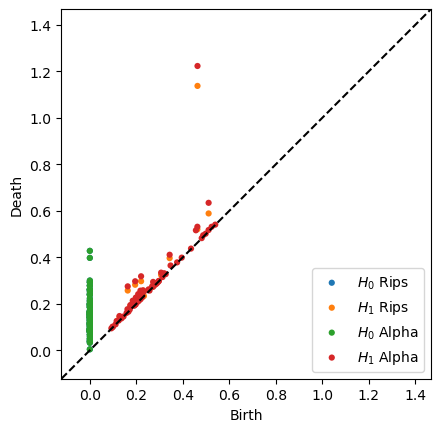

In [8]:
plot_diagrams(dgmsrips + dgmsalpha, labels = ['$H_0$ Rips', '$H_1$ Rips', '$H_0$ Alpha', '$H_1$ Alpha'])
plt.show()

Note that the alpha filtration is substantially faster than the Rips filtration, and it is also more geometrically accurate.  In rips, we add a triangle the moment its edges are added, but growing balls around their vertices do not necessarily cover the triangle at that point, as they are in the Cech filtration.  Alpha is the intersection of Cech balls with Voronoi regions, so it is a strict subset of Cech.  Hence, it takes a larger scale to add triangles, so the classes die slightly later.

Now let's try an example with a 400 points sampled from a 4-sphere in 5 dimensions.

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 1.71)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 151)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 3.12)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.495)


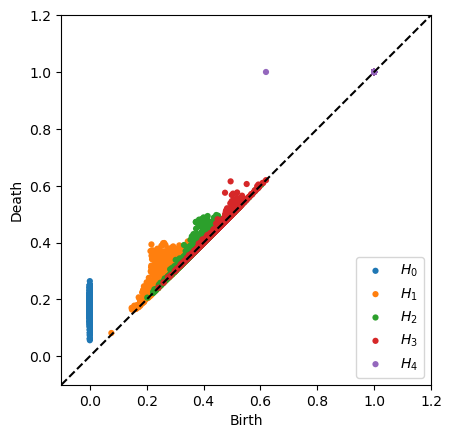

In [9]:
X = tadasets.dsphere(n=400, r=1, d=4)

alpha = cm.Alpha()
filtration = alpha.build(X)
dgms = alpha.diagrams(filtration)
plot_diagrams(dgms)
plt.show()

As expected, the only nontrivial homology is in $H_4$.  

Normally computing $H_4$ with that number of points would grind Rips to a halt, but it runs in a reasonable amount of time with Alpha. The bottleneck with Alpha is constructing the filtration and computing many circumcenters. Note that computing the persistence pairs takes even less time than H1 for Rips with only 100 points shown above.

## Custom filtration

### Using a filtration list

If you have a point cloud and a set of simplices with times at which they are added, you can compute the persistence diagrams associated to the custom filtration you've defined. For instance, assume we want to compute a filtration where 4 vertices enter at time 0 and the edges and triangles are added in the pattern below (note how the triangles are not added the moment all of their edges are added, unlike Rips):

<img src = "CustomExample.svg">

Then we can execute the following code:

In [10]:
filtration = [([0], 0), 
            ([1], 0), 
            ([2], 0), 
            ([3], 0), 
            ([0, 1], 1),
            ([0, 2], 1),
            ([1, 2], 2),
            ([0, 1, 2], 4),
            ([0, 3], 2),
            ([2, 3], 3),
            ([0, 2, 3], 6)]
#Compute persistence diagrams
dgms = cm.phat_diagrams(filtration, show_inf = True)
print("H0:\n", dgms[0])
print("H1:\n", dgms[1])

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.000251)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.000151)
H0:
 [[ 0.  1.]
 [ 0.  1.]
 [ 0.  2.]
 [ 0. inf]]
H1:
 [[2 4]
 [3 6]]


### Object oriented approach

If you have an algorithm which defines your filtration, you can also define a custom filtration using the class `cechmate.filtrations.custom.Custom`. Just define a subclass of `Custom` which includes a `.build()` method, and use it like the `Alpha` and `Rips` examples above.

In [11]:
%load_ext autoreload

In [12]:
%aimport cechmate.filtrations.custom
%autoreload 1

In [13]:
from cechmate.filtrations.custom import Custom

from math import factorial

from itertools import combinations

class SimplexSizeFiltration(Custom):
    """
    This filtration takes in a list of points, and builts up a simplex
    from them. The simplex has i-faces added at time i.
    """
    
    def build(self,X):
        
        simplices = list()
        
        n = len(X)
        
        for k in range(1,n+1):
            
            n_choose_k = int(factorial(n)/(factorial(k)*factorial(n-k)))
            
            simplices += list(zip(combinations(X,k),
                                  [k-1]*n_choose_k))
            
        return simplices
        
    

In [14]:
ssf = SimplexSizeFiltration()
simplices = ssf.build('abcd')
simplices

[(('a',), 0),
 (('b',), 0),
 (('c',), 0),
 (('d',), 0),
 (('a', 'b'), 1),
 (('a', 'c'), 1),
 (('a', 'd'), 1),
 (('b', 'c'), 1),
 (('b', 'd'), 1),
 (('c', 'd'), 1),
 (('a', 'b', 'c'), 2),
 (('a', 'b', 'd'), 2),
 (('a', 'c', 'd'), 2),
 (('b', 'c', 'd'), 2),
 (('a', 'b', 'c', 'd'), 3)]

In [15]:
simplex_size_dgms = ssf.diagrams(simplices,show_inf=True)

simplex_size_dgms

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.000219)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.00018)


[array([[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0., inf]]),
 array([[1, 2],
        [1, 2],
        [1, 2]]),
 array([[2, 3]])]

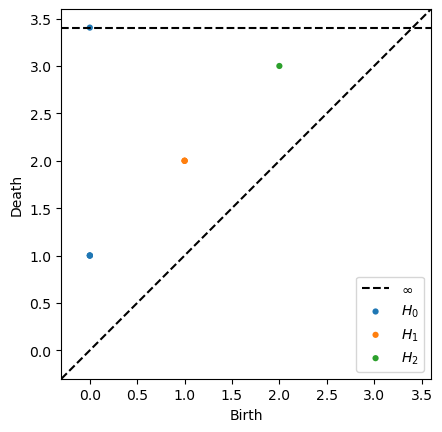

In [16]:
plot_diagrams(simplex_size_dgms)

It is also possible to define something a little more general than a simplicial complex. For example, we can construct the two-sphere $S^2$ as the $\Delta$-complex where there are 3 0-cells, with a 1-cell connecting each of them, and then two 2-cells with each boundary being the 1-skeleton consisting of 3 1-cells.

To see how this could be used with persistence, add the i-cells at time/distance i.

In [17]:
filtration = [('a',0),('b',0),('c',0),
              ('ab',1),('ac',1),('bc',1),
              ('abc',2),('abc',2)]

In [18]:
S2_cell_dgms = cm.phat_diagrams(filtration,show_inf=True)

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.000179)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.000127)


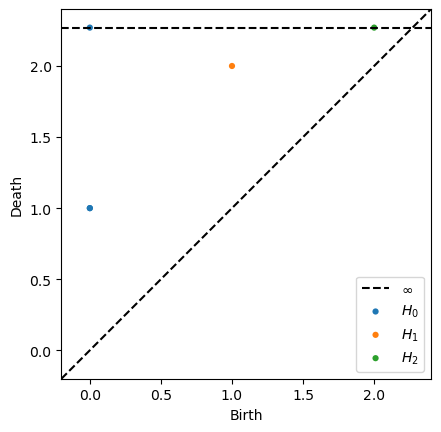

In [19]:
plot_diagrams(S2_cell_dgms)

As expected, the infinite persistence comes from the true homology of $S^2$, which is
$$H_n(S^2) = \begin{cases} \mathbb{Z} & n=0,2 \\ 0 &\text{else} \end{cases}$$

We could turn this into a simplicial complex by saying the two 2-cells `'abc'` and `'abc'` should only count once (which may be the intent of the given filtration in many circumstances). This is done by asserting that `simplicial=True` in the function call of `cm.phat_diagrams()`.

In [20]:
B2_simplicial_dgms = cm.phat_diagrams(filtration, show_inf=True, simplicial=True)

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.000104)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.000132)


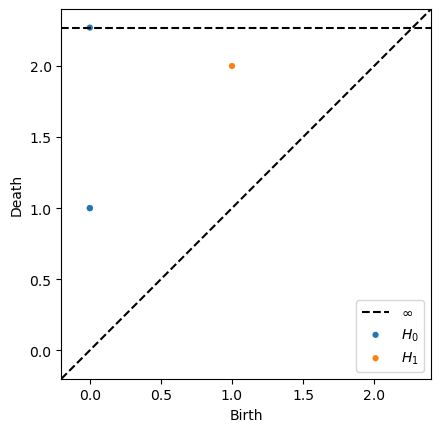

In [21]:
plot_diagrams(B2_simplicial_dgms)

By default, `cm.phat_diagrams()` is not neccessarily a simplicial complex, but if you design a `Custom` filtration, the default behavior is that it **is** a simplicial complex. This can be fixed by either:

1. Defining a `.diagrams()` method in your custom filtration builder which defaults to `simplicial=False` OR
2. Passing `simplicial = False` into the given `.diagrams()` method.